In [1]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, csv
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import LocallyLinearEmbedding
from tqdm import trange
#%matplotlib notebook
%matplotlib inline
import torch.nn as nn, timeit, torch, pystan as ps
from time import time
import matplotlib.pyplot as plt
from pylab import plot, show, legend

In [2]:
sm_refpoints = ps.StanModel(file="stan_files/nn_refpoints_constrainedX.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_570ec97f0e246bb0014b5b01f8cd50dd NOW.


In [3]:
M = 1000
X = 10*npr.rand(2,M)
Y = np.zeros((3,M))
Y[0] = np.cos(X[0])*np.cos(X[1])
Y[1] = np.cos(X[0])*np.sin(X[1])
Y[2] = np.sin(X[0])

idx = Y[2]>0
Y = Y[:,idx]
X = X[:,idx]
Y += 0.1*npr.rand(*np.shape(Y))
Nobs = np.shape(X)[1]

### Local linear embedding for reference points:

In [4]:
n_ref = 40
ref_points = npr.choice(Nobs,n_ref,replace=False)
embedding = LocallyLinearEmbedding(n_components=2,n_neighbors=10)
Y_embedded = embedding.fit_transform(Y.transpose()).transpose()

In [5]:
train = np.setdiff1d(np.arange(Nobs), ref_points)
Y_ref = Y[:,ref_points]
X_ref = Y_embedded[:,ref_points]
Y_train = Y[:,train]

In [6]:
for i in range(np.shape(X_ref)[1]) :
    X_ref[:,i] /= np.linalg.norm(X_ref[:,i])

In [7]:
n_in = np.shape(Y_embedded)[0]
n_h = 50
n_out = np.shape(Y)[0]

model = nn.Sequential(nn.Linear(n_in, n_h),
                      nn.Tanh(),
                      nn.Linear(n_h, n_out))

In [8]:
def init_normal(m):
    if type(m) == nn.Linear: nn.init.normal_(m.weight)
model.apply(init_normal)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

In [9]:
n_iter = 50_000
start = time()
for epoch in range(n_iter):
    y_pred = model(torch.from_numpy(X_ref.transpose().astype(np.float32)))
    loss = criterion(y_pred, torch.from_numpy(Y_ref.transpose().astype(np.float32)))
    if (epoch+1)%(n_iter/10) == 0 :
        print("Epoch: %d; loss: %.3f; time: %.1f mins" % (epoch+1, loss.item(), (time()-start)/60))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 5000; loss: 0.076; time: 0.0 mins
Epoch: 10000; loss: 0.072; time: 0.0 mins
Epoch: 15000; loss: 0.070; time: 0.1 mins
Epoch: 20000; loss: 0.069; time: 0.1 mins
Epoch: 25000; loss: 0.068; time: 0.1 mins
Epoch: 30000; loss: 0.067; time: 0.1 mins
Epoch: 35000; loss: 0.066; time: 0.2 mins
Epoch: 40000; loss: 0.065; time: 0.2 mins
Epoch: 45000; loss: 0.064; time: 0.2 mins
Epoch: 50000; loss: 0.064; time: 0.2 mins


In [10]:
data_refpoints = dict(Nobs=Nobs, 
                      in_dim=np.shape(X)[0], 
                      out_dim=np.shape(Y)[0], 
                      hidden_dim=n_h,
                      n_ref=np.shape(Y_ref)[1],
                      y=Y_train, 
                      y_ref=Y_ref,
                      X_ref=X_ref)

### Run Stan:

In [11]:
control = dict(adapt_delta=0.9, max_treedepth=12)
start = time()
fit_refpoints_lle = sm_refpoints.sampling(data=data_refpoints, thin=1, n_jobs=6, chains=6,
                                      init="random", iter=1_000, control=control)
print(round((time()-start)/60,2), "minutes to run")
print(fit_refpoints_lle);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


493.78 minutes to run
Inference for Stan model: anon_model_570ec97f0e246bb0014b5b01f8cd50dd.
6 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=3000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
X[1,1]               0.57    0.27   0.48  -0.48   0.55   0.65   0.99    1.0      3   13.2
X[2,1]               0.14    0.51   0.89   -1.0  -0.97   0.44    1.0    1.0      3  24.94
X[3,1]               0.35    0.35   0.61  -0.69  -0.26   0.72   0.84   0.94      3   8.07
X[4,1]                0.2    0.38   0.66  -0.68  -0.43   0.05   0.84   0.95      3  13.06
X[5,1]               0.38    0.39   0.67  -0.92  -0.13   0.78   0.85    0.9      3  24.93
X[6,1]              -0.07    0.38   0.65  -0.88  -0.66  -0.26   0.69   0.77      3  10.95
X[7,1]              -0.07    0.33   0.58  -0.82  -0.61  -0.04   0.62   0.74      3  13.51
X[8,1]               0.66    0.19   0.33  -0.08   0.71   0.76   0.81   

In [12]:
trace = fit_refpoints_lle.extract()
n_samples = np.shape(trace['X'])[0]
n_latent = np.shape(trace['X'])[1]

### Traceplots of latent variables:

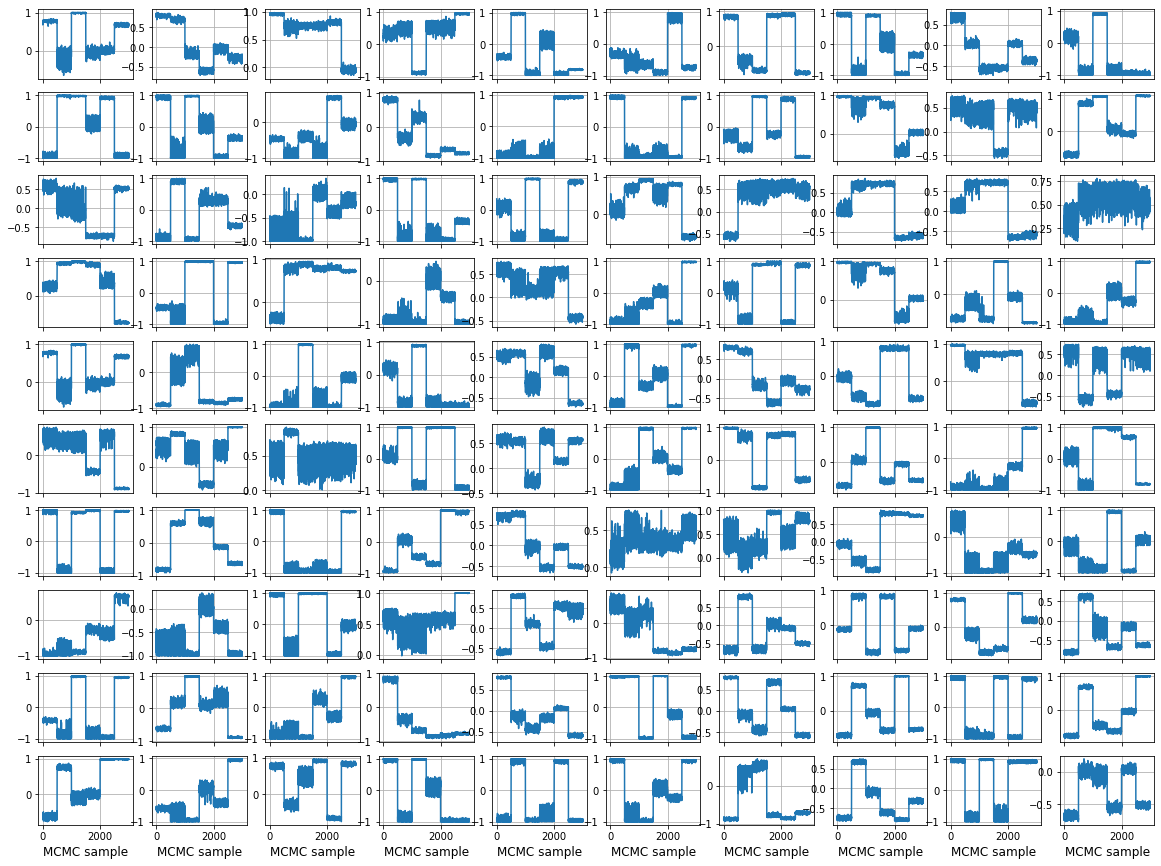

In [13]:
plt.figure(figsize=(20,15))
idx = npr.choice(n_latent,100).reshape(10,10)

for i in range(10):
    for j in range(10):
        k = 10*i+j
        plt.subplot(10,10,k+1)
        plt.plot(trace['X'][:,idx[i,j],0])
        if i < 9 : plt.xticks(alpha=0)
        if i == 9 : plt.xlabel("MCMC sample", fontsize=12)
        plt.grid(True)
plt.show()

### Loss:

In [14]:
def L2_loss(Y, X, weights_1, bias_1, weights_2, bias_2) :
    Y_pred = np.matmul(np.tanh(np.matmul(X,weights_1)+bias_1), weights_2) + bias_2
    return np.mean(np.sum((Y-Y_pred)**2,axis=1))

100%|██████████| 3000/3000 [00:02<00:00, 1365.56it/s]


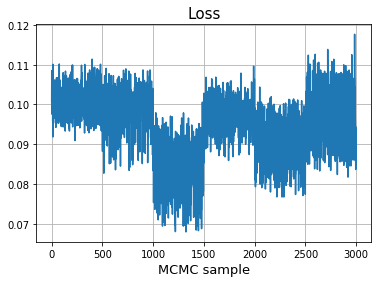

In [15]:
loss = np.zeros(n_samples)
for i in trange(n_samples) :
    loss[i] = L2_loss(Y_train.transpose(), trace['X'][i], trace['weights_1'][i], 
                      trace['bias_1'][i], trace['weights_2'][i], trace['bias_2'][i])
plt.plot(loss)
plt.title("Loss", fontsize=15)
plt.xlabel("MCMC sample", fontsize=13)
plt.grid(True);

### Pairwise distances:

In [16]:
pw_dist_matrix = np.zeros((n_latent,n_latent,n_samples))
for i in trange(100) :
    for j in range(100) :
        for k in range(n_samples) :
            pw_dist_matrix[i,j,k] = np.linalg.norm(trace['X'][k,i]-trace['X'][k,j])

100%|██████████| 100/100 [02:26<00:00,  1.43s/it]


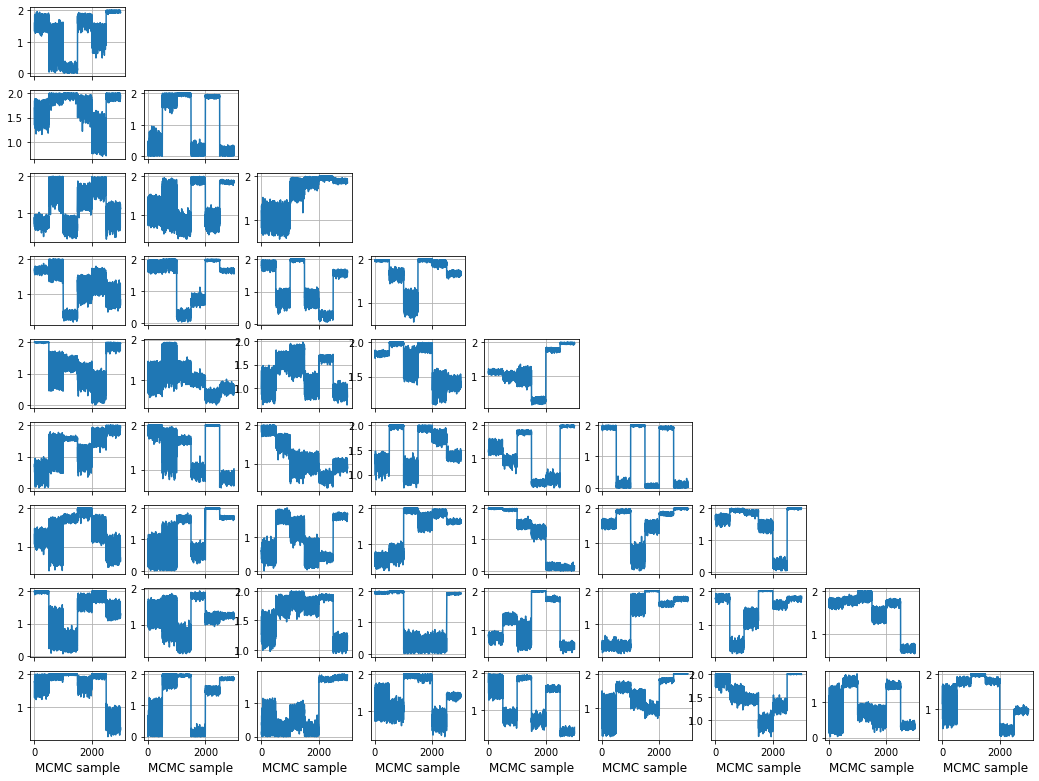

In [17]:
idx = npr.choice(100,10,replace=False)
plt.figure(figsize=(20,15))
for i in range(10):
    for j in range(10):
        if i > j :
            k = 10*i+j+1
            plt.subplot(10,10,k)
            plt.plot(pw_dist_matrix[idx[i],idx[j]])
            if i < 9 : plt.xticks(alpha=0)
            plt.grid(True)
            if i == 9 : plt.xlabel("MCMC sample", fontsize=12)